# Milestone P3

# Milestone Objectives

- Execute the project: single final notebook (main logic), helpers python file (implementations functions).

- Write a data story

- Update README: details the contributions of all group members.

[Milestone P3 briefing](https://epfl-ada.github.io/teaching/fall2023/cs401/projects/#p3-final-project-and-the-datastory)

In [4]:
!pip install pyarrow


  Obtaining dependency information for pyarrow from https://files.pythonhosted.org/packages/28/82/9adfafaf0de581a39a1c86002cafd1a55a1255c9e0d362dc3e970aab0656/pyarrow-14.0.1-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/24.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.6 MB 445.2 kB/s eta 0:00:56
   ---------------------------------------- 0.1/24.6 MB 550.5 kB/s eta 0:00:45
   ---------------------------------------- 0.2/24.6 MB 1.0 MB/s eta 0:00:24
    --------------------------------------- 0.5/24.6 MB 2.7 MB/s eta 0:00:09
   -- ------------------------------------- 1.4/24.6 MB 5.8 MB/s eta 0:00:04
   --- ------------------------------------ 2.1/24.6 MB 7.6 MB/s eta 0:00:03
   ---- ----------------------------------- 2.9/24.6 MB 8.8 MB/s eta 0:00:03
   ----- ---------------------------------- 3.5/24.6 MB 9.4 MB/s eta 0:00:03
   ------ -----------------------

In [20]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

from helpers import *
from implementations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
import re
import statsmodels.api as sm

import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%run ./milestoneP2.ipynb

In [12]:
display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part
4255,2619545,/m/07s6fh,The Tin Star,1957,92.0,[English Language],[USA],"[Action/Adventure, Western, Drama, Romance Film]",NaN,NaN,1400000.0,0.004514
4067,1126385,/m/048htn,Unfaithful,2002,123.0,"[French Language, English Language]","[USA, France, Germany]","[Thriller, Crime Fiction, Erotica, Erotic thri...",NaN,NaN,119137784.0,0.007249
7072,9222319,/m/0280rjy,Something Of Value,1957,113.0,[English Language],[USA],"[Historical fiction, Drama, Political drama, B...",NaN,NaN,3600000.0,0.011607
6509,2236329,/m/06y611,The Parent Trap,1998,127.0,"[French Language, English Language]",[USA],"[Romance Film, Family Film, Drama, Comedy, Adv...",NaN,NaN,92108518.0,0.008302
1806,692652,/m/0337v7,Stakeout,1987,117.0,[English Language],[USA],"[Action/Adventure, Romantic comedy, Romance Fi...",6.6,24000.0,65673233.0,0.015921


(7285, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_wiki       7285 non-null   int64  
 1   id_freebase   7285 non-null   object 
 2   name          7285 non-null   object 
 3   year          7285 non-null   int32  
 4   runtime       7260 non-null   float64
 5   lang          7285 non-null   object 
 6   countries     7285 non-null   object 
 7   genres        7285 non-null   object 
 8   review        2898 non-null   float64
 9   nbr_review    2898 non-null   float64
 10  revenue       7285 non-null   object 
 11  revenue_part  7285 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 654.6+ KB


None

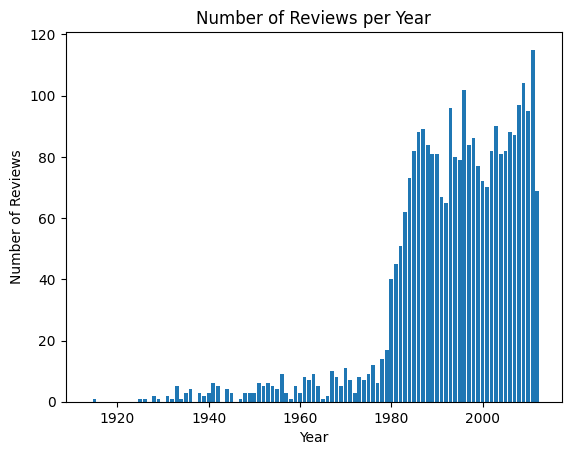

In [ ]:
reviews_count_per_year = movies2_clean.groupby('year')['review'].count().reset_index()

plt.bar(reviews_count_per_year['year'], reviews_count_per_year['review'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.show()

# Structure

## 0) Overview of the data used 

### revenue normalization

#### US dollar inflation
Due to inflation, one dollar in 1914 (the earliest date of release for a movie in the dataset) compared to one dollar in 2012 (most recent one in the dataset) does not have the same value. The purchasing power of the money has changed and this effect has to be accounted for, if two movies from different moments in time are compared to each other. This is done with an additional [dataset](https://www.officialdata.org/us/inflation/1800?amount=1#buying-power):

In [ ]:
DATA_PATH = '../data'
INFLATION_PATH = '/inflation/inflation_data.csv'
inflation_raw= pd.read_csv(DATA_PATH+INFLATION_PATH)
display(inflation_raw.sample(5))
display(inflation_raw.shape)
display(inflation_raw.info())

,year,amount,inflation rate
52,1852,0.61,0.00
78,1878,0.79,-0.05
163,1963,2.43,0.01
207,2007,16.46,0.03
133,1933,1.03,-0.05


(224, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            224 non-null    int64  
 1   amount          224 non-null    float64
 2   inflation rate  224 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.4 KB


None

In [ ]:
# only keep years from 1920 to max in movies dataset (2012)
inflation = inflation_raw[(inflation_raw['year'] >= movies2_clean.year.min()) & (inflation_raw['year'] <= movies2_clean.year.max()) & (~inflation_raw['year'].isin({1916,1917,1918,1919,1922}))][['year','amount']]
movies_inflation_raw = movies2_clean[~movies2_clean['year'].isin({1916,1917,1918,1919,1922})]

# merge data on 'year'
movies_inflation = pd.merge(movies_inflation_raw, inflation, on='year', how='left')

# divide 'revenue' by 'amount'
movies_inflation['revenue_infl'] = movies_inflation['revenue'] / movies_inflation['amount']

# drop 'amount' and 'revenue' columns
movies_inflation = movies_inflation.drop(columns=['amount'])

movies_inflation

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,revenue_infl
0,975900,/m/03vyhn,Ghosts of Mars,2001,98.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Adventure,...",4.899428,52299.0,14010832.0,0.000989,996502.987198
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]",4.800000,6.0,3800000.0,0.130612,3392857.142857
2,77856,/m/0kcn7,Mary Poppins,1964,139.0,[English Language],[USA],"[Children's/Family, Musical, Fantasy, Comedy, ...",7.400000,1217.0,102272727.0,0.473545,41574279.268293
3,612710,/m/02wjqm,New Rose Hotel,1999,92.0,[English Language],[USA],"[Thriller, Science Fiction, Future noir, Indie...",NaN,NaN,21521.0,0.000002,1627.912254
4,156558,/m/014k4y,Baby Boy,2001,123.0,[English Language],[USA],"[Crime Fiction, Drama, Coming of age]",NaN,NaN,29381649.0,0.002074,2089733.214794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7280,4492078,/m/0c5clj,How to Eat Fried Worms,2006,98.0,[English Language],[USA],"[Family Film, Drama, Comedy, Film adaptation]",5.100000,20.0,13031641.5,0.000742,814477.59375
7281,6740261,/m/0glmbl,Eternally Yours,1939,91.0,[English Language],[USA],"[Family Drama, Black-and-white, Drama, Comedy,...",NaN,NaN,683131.0,0.001557,621028.181818
7282,54540,/m/0f7hw,Coming to America,1988,117.0,[English Language],[USA],"[Romantic comedy, Comedy of manners, Drama, Co...",7.100000,196000.0,288752301.0,0.060752,30751043.769968
7283,7761830,/m/0kvgqb,Spaced Invaders,1990,100.0,[English Language],[USA],"[Alien Film, Science Fiction, Family Film, Com...",5.295942,3327.0,15369573.0,0.002205,1482118.900675


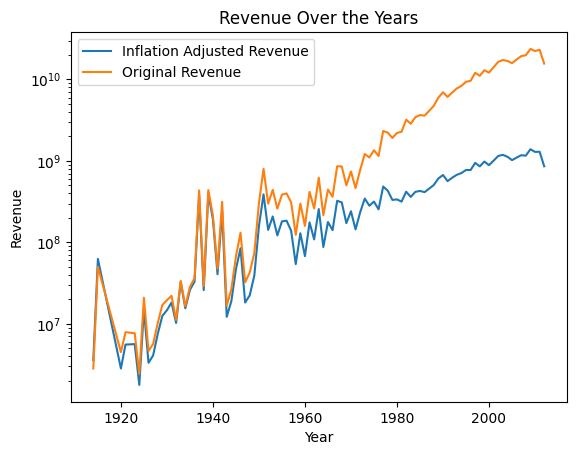

In [ ]:
revenue_year_infl = movies_inflation.groupby(['year']).revenue_infl.sum()
revenue_year_orig = movies_inflation.groupby(['year']).revenue.sum()

# Plot the adjusted and original revenues
plt.semilogy(inflation['year'], revenue_year_infl, label='Inflation Adjusted Revenue')
plt.semilogy(inflation['year'], revenue_year_orig, label='Original Revenue')
plt.title('Revenue Over the Years')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [ ]:
movies_inflation[movies_inflation['year'] == 1915]

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,revenue_infl
118,73395,/m/0jq8r,The Cheat,1915,59.0,[English Language],[USA],"[Silent film, Drama, Indie, Black-and-white]",4.8,11.0,137365.0,0.00274,171706.25
235,3333,/m/0151l,The Birth of a Nation,1915,190.0,"[Silent film, English Language]",[USA],"[Silent film, Indie, Costume drama, Epic, Blac...",NaN,NaN,50000000.0,0.99726,62500000.0


The very high total revenue in the year 1915 catches the eye, but the data for it is valid. In 1915 the movie "The Birth of a Nation" was released, which is a movie that was extremely succesfull and had a box office revenue of about 50-100 Mio US$. 

The steady increase in total revenue over time can be explained by the ever increasing number of movies released (and the number of movies in the dataset), as well as the growing size of the movie industry (internationally succesfull movies for example). To counter the effect of general growth of the movie industry (which does not reflect how succesfull an individual movie was but rather how the industry itself developed), a regression analysis is performed and the data normalized accordingly. 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.495
Model:                            OLS   Adj. R-squared (uncentered):              0.490
Method:                 Least Squares   F-statistic:                              91.22
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                    1.82e-15
Time:                        09:51:17   Log-Likelihood:                         -1990.3
No. Observations:                  94   AIC:                                      3983.
Df Residuals:                      93   BIC:                                      3985.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

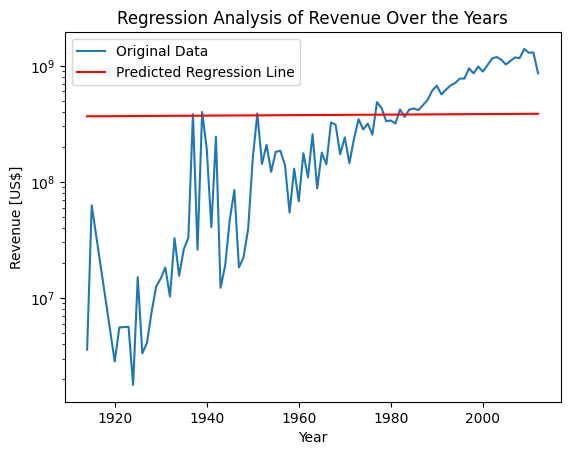

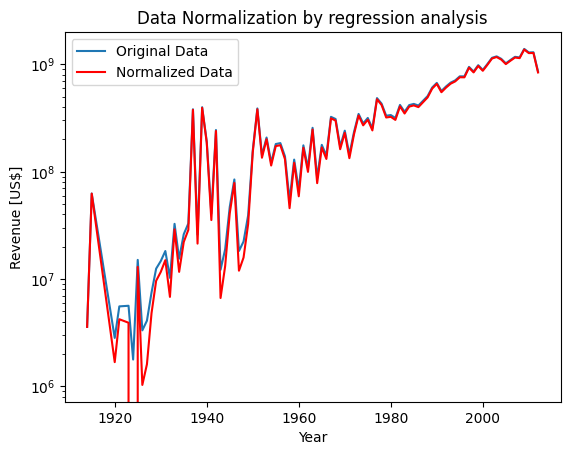

In [ ]:
# Define the predictor variable and the dependent variable
X = inflation['year'].astype(float)
y = revenue_year_infl.astype(float)
# transfortm into np.array
y = np.asarray(y)
X = np.asarray(X)

# Create a statsmodels regression model
model = sm.OLS(y, X).fit()
# Print the regression results
print(model.summary())

# Predict the revenue using the model
y_pred = model.predict(X)

# Plot the original data points and the predicted regression line
plt.semilogy(X, y, label='Original Data')
plt.semilogy(X, y_pred, color='red', label='Predicted Regression Line')
plt.title('Regression Analysis of Revenue Over the Years')
plt.xlabel('Year')
plt.ylabel('Revenue [US$]')
plt.legend()
plt.show()

# normalize the data
relative_revenue = revenue_year_infl - (y_pred - y_pred[0]*np.ones(y_pred.size))

# Plot the original and normalized data points
plt.semilogy(X, y, label='Original Data')
plt.semilogy(X, relative_revenue, color='red', label='Normalized Data')
plt.title('Data Normalization by regression analysis')
plt.xlabel('Year')
plt.ylabel('Revenue [US$]')
plt.legend()
plt.show()

In [ ]:
revenue_normalized = relative_revenue.reset_index()
revenue_normalized.rename(columns={"year": "year", "revenue_infl": "revenue_infl_tot"}, inplace=True)

# merge data on 'year'
movies_inflation = pd.merge(movies_inflation, revenue_normalized, on='year', how='left')

movies_inflation['revenue_norm'] = movies_inflation['revenue_part'] * movies_inflation['revenue_infl_tot']
# drop 'amount' and 'revenue_infl_tot' columns
movies_inflation = movies_inflation.drop(columns=['revenue_infl_tot'])
movies_inflation

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,revenue_infl,revenue_norm
0,975900,/m/03vyhn,Ghosts of Mars,2001,98.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Adventure,...",4.899428,52299.0,14010832.0,0.000989,996502.987198,980043.885155
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]",4.800000,6.0,3800000.0,0.130612,3392857.142857,2793357.313264
2,77856,/m/0kcn7,Mary Poppins,1964,139.0,[English Language],[USA],"[Children's/Family, Musical, Fantasy, Comedy, ...",7.400000,1217.0,102272727.0,0.473545,41574279.268293,37046070.211852
3,612710,/m/02wjqm,New Rose Hotel,1999,92.0,[English Language],[USA],"[Thriller, Science Fiction, Future noir, Indie...",NaN,NaN,21521.0,0.000002,1627.912254,1600.988042
4,156558,/m/014k4y,Baby Boy,2001,123.0,[English Language],[USA],"[Crime Fiction, Drama, Coming of age]",NaN,NaN,29381649.0,0.002074,2089733.214794,2055217.380255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7280,4492078,/m/0c5clj,How to Eat Fried Worms,2006,98.0,[English Language],[USA],"[Family Film, Drama, Comedy, Film adaptation]",5.100000,20.0,13031641.5,0.000742,814477.59375,801428.954708
7281,6740261,/m/0glmbl,Eternally Yours,1939,91.0,[English Language],[USA],"[Family Drama, Black-and-white, Drama, Comedy,...",NaN,NaN,683131.0,0.001557,621028.181818,613582.133778
7282,54540,/m/0f7hw,Coming to America,1988,117.0,[English Language],[USA],"[Romantic comedy, Comedy of manners, Drama, Co...",7.100000,196000.0,288752301.0,0.060752,30751043.769968,29891259.631449
7283,7761830,/m/0kvgqb,Spaced Invaders,1990,100.0,[English Language],[USA],"[Alien Film, Science Fiction, Family Film, Com...",5.295942,3327.0,15369573.0,0.002205,1482118.900675,1450063.874


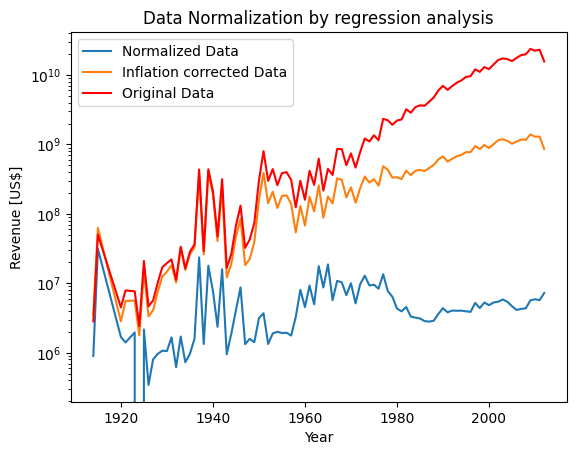

In [ ]:
revenue_year_norm = movies_inflation.groupby(['year'])['revenue_norm'].mean()

# Plot the original and normalzed data points
plt.semilogy(X, revenue_year_norm, label='Normalized Data')
plt.semilogy(X, revenue_year_infl, label='Inflation corrected Data')
plt.semilogy(X, revenue_year_orig, color='red', label='Original Data')
plt.title('Data Normalization by regression analysis')
plt.xlabel('Year')
plt.ylabel('Revenue [US$]')
plt.legend()
plt.show()

In [ ]:
# ça semble un peu bizarre la nomalization, est-ce que j'ai fait une faute qqp?

## 1) Finding Potential pivotal movies

In this section, we will first analyze trends in specific genres of movies, focusing on those that are more niche and specific, such as Science Fiction, Teen, and Biography. The objective is to uncover patterns and insights within these specialized genres, as opposed to broader categories like Action or Adventure. We need to be careful to not choosing genre that are too niche because the set of movie will be too small to be analysed. 

After obtaining the trends we could be able to identify, for each trend, a subset of movies that could have strat the trend (i.e. pivotal movies)

In [ ]:
# Data Path
DATA_PATH = '../data/'
MOVIES_FOLDER = DATA_PATH+'MovieSummaries/'
MOVIES_DATASET = MOVIES_FOLDER+"movie.metadata.tsv"

# Load Data
df_raw = pd.read_csv(MOVIES_DATASET, sep='\t', names=['id_wiki','id_freebase','name','date',
                                                  'box_office','runtime','lang','countries','genres'])

In [ ]:
# MILESTONE P2
movies = df_raw.copy()
movies = data_missing(movies)
movies = fuse_duplicates(movies, col_check=['name'], year='date', runtime='runtime',
                         col_len=['lang', 'countries', 'genres'], col_null=['box_office', 'runtime'])
movies = data_format(movies)
movies.rename(columns={'box_office': 'revenue'}, inplace=True)  # maybe add this inside data_format ?
movies.rename(columns={'date': 'year'}, inplace=True)           # maybe add this inside data_format ?
movies = data_clean(movies)
movies_all= movies.copy() # copy of all movies before filtering
movies = data_filter(movies)

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------


### a) Selection of niches genre

In [ ]:
import itertools
all_genres = list(set(itertools.chain.from_iterable(movies.genres.tolist())))
subsets = [(s,create_subset(movies,s)) for s in all_genres]

### b) Trend graphs for some genres


Subset: Childhood Drama
	69 | 29828 (size subset | movies)
	= 0.0023 %


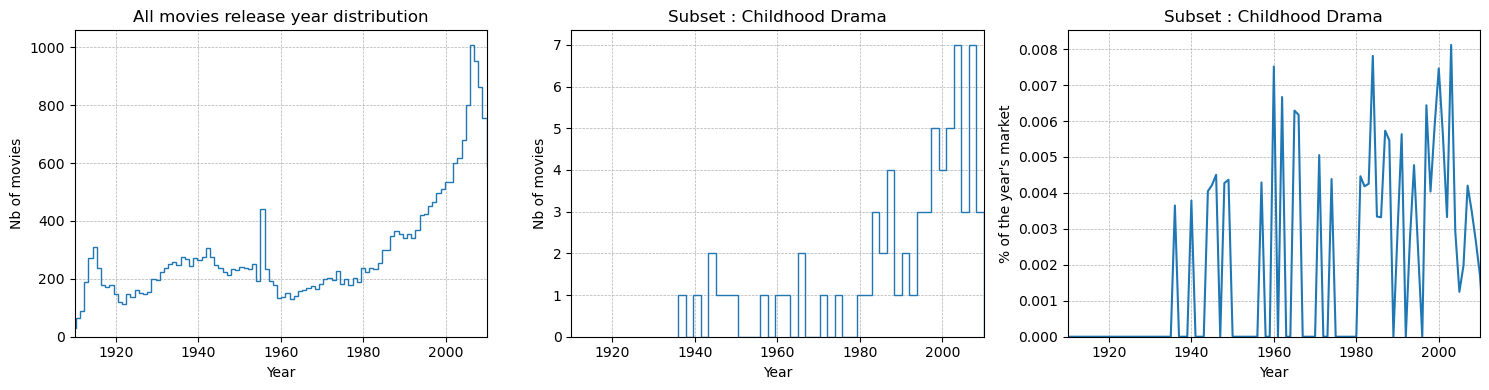

In [ ]:
# VISUALIZE SUBSET i
i = 1
viz_subset(i, subsets, movies)

### c) Trend automatic detection

In [ ]:
get_peaks(movies, subsets, 15)

[1947, 1989]

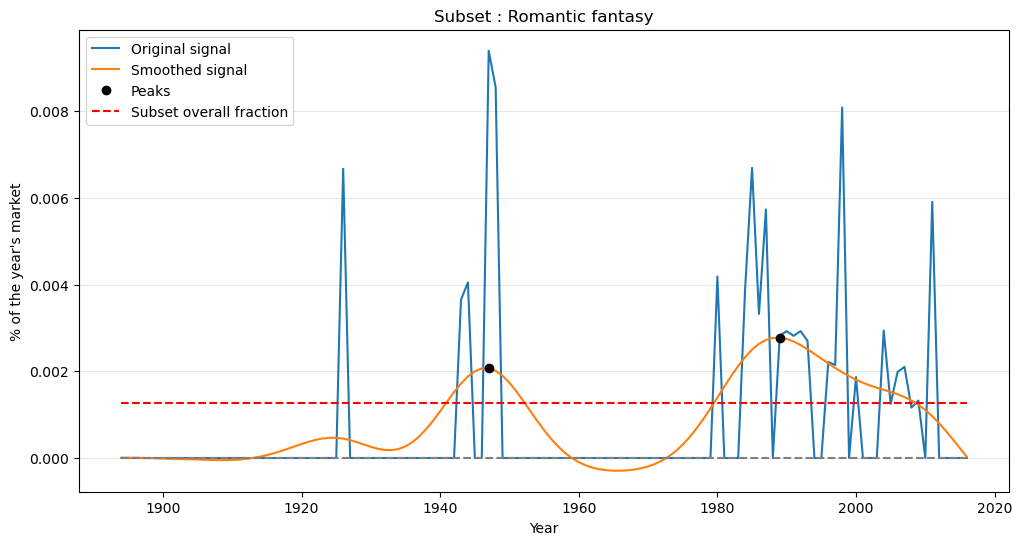

In [ ]:
viz_peaks(movies, subsets, 15)

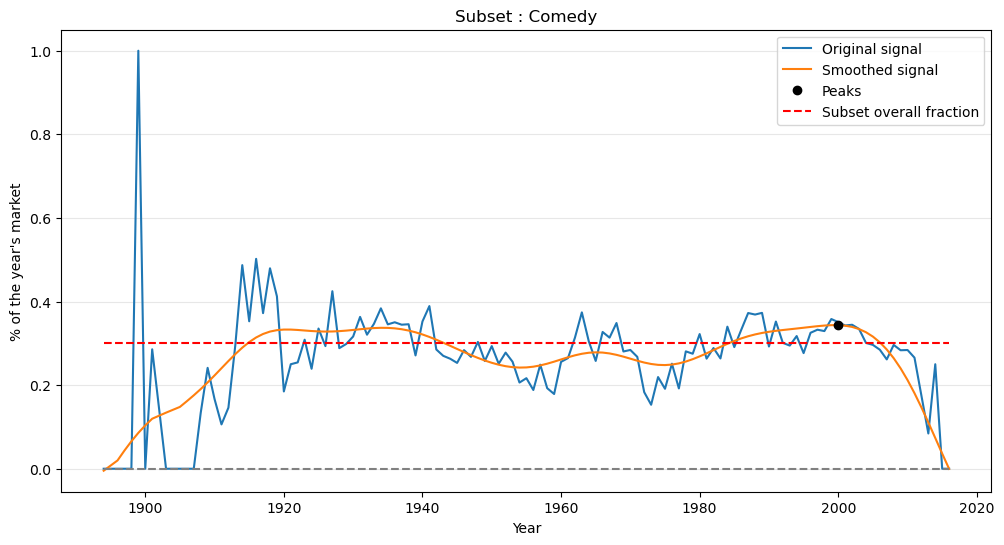

In [ ]:
viz_peaks(movies, subsets, find_subset(subsets, 'Comedy'))

### d) Construction of potential pivotal movie sets 
 

In [ ]:
subsets_trends = [(s[0], get_peaks(movies, subsets, i)) for i, s in enumerate(subsets)]

## 2) Metric assessment for Pivotal Movies identification

Identifying the pivotal movie, or the one that starts a trend, involves a combination of qualitative and quantitative analysis. Here are considerations and steps to help define the chosen pivotal movie within a specific genre:

 - **Box-office Revenue :**
    Analyze the box-office performance of candidate movies within the subset. The pivotal movie often exhibits exceptional financial success, indicating a strong audience demand for the particular genre or theme. We need then to look for movies that surpassed industry expectations in terms of revenue. Also comparing the box-office performance of candidate movies to industry standards and consider their impact on subsequent films' budgeting and revenue expectations.

- **Reviews :**
   Critical reception is a key indicator of a movie's impact and lasting influence. The pivotal movie should have received positive reviews from both critics and audiences, showcasing its quality and appeal. To this aims we incorporate a new dataset that includes review. These review will be a measuremnent of how good a movie is . This metric is fundamental to identify the pivotal movie : if a film is considered as bad there is no chance that it influence the cinema industry and creating a trend.

- **Awards :**
Another measure for assessing influence is the recognition garnered through awards. Industry accolades serve as a validation of a movie's cultural and artistic significance. The receipt of awards signifies not only the excellence of the film but also its potential to set a standard worth emulating. It provides more precise insights into why the film is esteemed. Noteworthy awards include prestigious honors like the Oscars or Golden Globes. In our analysis, we have opted to incorporate a dataset that encompasses these awards and their respective categories.

- **Plot Similarity:**
  This metric serves as an assessment of the extent to which a film influences others within the genre during trends. The concept is as follows: if the plot of a potential pivotal film closely resembles those observed in subsequent trend films when compared to other movies in the candidate subset, it indicates the film's influence on plot development. This similarity suggests that other films intentionally emulated the storyline, signifying the impactful nature of the pivotal film.



All these metrics will be exploited to select the pivotal film among the candidate subset. But to use it we need to properly define function which calculate from available data or simply add missing data from other dataset.


### a) Box-office revenue

### b) Reviews

### c) Awards

### d) Plot similarity

In [14]:
print(movies2_clean)

       id_wiki id_freebase                      name  year  runtime  \
0       975900   /m/03vyhn            Ghosts of Mars  2001     98.0   
1     10408933  /m/02qc0j7  Alexander's Ragtime Band  1938    106.0   
2        77856    /m/0kcn7              Mary Poppins  1964    139.0   
3       612710   /m/02wjqm            New Rose Hotel  1999     92.0   
4       156558   /m/014k4y                  Baby Boy  2001    123.0   
...        ...         ...                       ...   ...      ...   
7280   4492078   /m/0c5clj    How to Eat Fried Worms  2006     98.0   
7281   6740261   /m/0glmbl           Eternally Yours  1939     91.0   
7282     54540    /m/0f7hw         Coming to America  1988    117.0   
7283   7761830   /m/0kvgqb           Spaced Invaders  1990    100.0   
7284   1918494   /m/0660qx            State and Main  2000    106.0   

                                      lang      countries  \
0                       [English Language]          [USA]   
1                       [

In [22]:
# Example usage
MOVIES_PLOT = MOVIES_FOLDER + "plot_summaries.txt"
df_plot = pd.read_csv(MOVIES_PLOT, sep='\t', names=['id_wiki', 'plot'])
# Replace this line with your actual DataFrame
merged_df = df_plot.merge(movies2_clean, on='id_wiki')

similarity_matrix = plot_similarity_heatmap(merged_df, 'plot')

# Example to find most similar movie
given_movie_index = 1665  # Replace with the index of the movie you're interested in
max_indices = np.argpartition(similarity_matrix[given_movie_index], -2)[-2:]
given_movie_name = merged_df.iloc[given_movie_index]['name']
most_similar_movie_names = merged_df.iloc[max_indices[0]]['name']

print("Given Movie Name:", given_movie_name)
print("Most Similar Movie Names:", most_similar_movie_names)
print(max_indices)

## 3) Method for identifying pivotal movies

### a) Method 1 : Machine learning

In this subsection we aim to identify the

### b) (TO COMPLETE)

## 4) Analysis of the results 

We finally got the set of pivotals movies but we need to do an assessment of these results. 

### a) Convergence of the methods

### b) Correlation between pivotal movies

### c) How to make a pivotal movie ?

# MEHDI

In [ ]:
# Pre merge df of m2:

display(movies.sample(5))
display(movies.shape)
display(movies.info())

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
13874,29000018,/m/0dgqy8z,Jack Goes Boating,2010,619570.0,89.0,[English Language],[USA],"[Romantic comedy, Romance Film, Drama, Comedy]"
69858,19403408,/m/04n0403,The Pirates of Central Park,2001,NaN,NaN,[English Language],[USA],"[Short Film, Family Film, Adventure]"
9002,5247666,/m/0d9v79,The Princess Comes Across,1936,NaN,76.0,[English Language],[USA],"[Mystery, Comedy, Black-and-white, Whodunit]"
19873,492200,/m/02gz9t,S.O.B.,1981,14867086.0,121.0,[English Language],[USA],"[Black comedy, Sex comedy, Satire, Tragicomedy..."
41357,930894,/m/03r1rz,Lovin' Molly,1974,NaN,98.0,[English Language],[USA],"[Romantic drama, Romance Film, Drama]"


(29828, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 29828 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      29828 non-null  int64  
 1   id_freebase  29828 non-null  object 
 2   name         29828 non-null  object 
 3   year         29828 non-null  int32  
 4   revenue      6779 non-null   float64
 5   runtime      26436 non-null  float64
 6   lang         29828 non-null  object 
 7   countries    29828 non-null  object 
 8   genres       29828 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.2+ MB


None

In [ ]:
CHARACTERS_DATASET = MOVIES_FOLDER + 'character.metadata.tsv'
# char_df = pd.read_csv(CHARACTERS_DATASET, sep='\t', encoding='utf-8', names=['id_wiki','id_freebase', 'year', 'char_name', 'actor_DOB', 'actor_gender',
#                                                                               'actor_height', 'actor_ethn', 'actor_name', 'actor_age', 'freebase_map'])

char_df = pd.read_csv(CHARACTERS_DATASET, sep='\t', header=None).drop(columns=[7, 10, 11, 12]).rename(columns={0: 'id_wiki',
                                                                                                               1: 'id_freebase',
                                                                                                               2: 'year',
                                                                                                               3: 'char_name',
                                                                                                               4: 'char_dob',
                                                                                                               5: 'char_gender',
                                                                                                               6: 'char_height',
                                                                                                               8: 'actor_name',
                                                                                                               9: 'actor_age'})
print(char_df.columns)

display(char_df.sample(5))
display(char_df.shape)
display(char_df.info())

Index(['id_wiki', 'id_freebase', 'year', 'char_name', 'char_dob',
       'char_gender', 'char_height', 'actor_name', 'actor_age'],
      dtype='object')


,id_wiki,id_freebase,year,char_name,char_dob,char_gender,char_height,actor_name,actor_age
273829,2275930,/m/04csl0k,1986-02-14,NaN,1925-02-25,M,NaN,Bert Remsen,60.0
263890,9086113,/m/027x4j2,2004-05-16,NaN,NaN,M,NaN,John Barry,NaN
395257,3755662,/m/09z8d1,1999-11-05,NaN,1929-11-15,M,1.7,Ed Asner,69.0
73366,13699003,/m/03cffvv,1993-09-11,NaN,1955-06-21,M,NaN,David Marshall Grant,38.0
177624,25851654,/m/09v3py5,1974-08-03,NaN,1928-03-10,M,NaN,Kiyoshi Atsumi,46.0


(450669, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id_wiki      450669 non-null  int64  
 1   id_freebase  450669 non-null  object 
 2   year         440674 non-null  object 
 3   char_name    192794 non-null  object 
 4   char_dob     344524 non-null  object 
 5   char_gender  405060 non-null  object 
 6   char_height  154824 non-null  float64
 7   actor_name   449441 non-null  object 
 8   actor_age    292556 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 30.9+ MB


None

## Wiki Award dataset

In [ ]:
DATA_PATH = '../data'
WIKI_AWARD_PATH = '/awardsWiki/oscar.csv'

In [ ]:
wiki_awards = pd.read_csv(DATA_PATH+WIKI_AWARD_PATH)
display(wiki_awards.sample(5))
display(wiki_awards.shape)
display(wiki_awards.info())

,Unnamed: 0,Film,Year,Award,Nomination
215,215,Smile Pinki,2008,1,1
443,443,Indochine,1992,1,2
897,897,The Cat Concerto,1946,1,1
1325,1325,Watch on the Rhine,1943,1,4
39,39,My Octopus Teacher,21,1,1


(1360, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1360 non-null   int64 
 1   Film        1359 non-null   object
 2   Year        1360 non-null   int64 
 3   Award       1360 non-null   int64 
 4   Nomination  1360 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 53.2+ KB


None

In [ ]:
display(wiki_awards[wiki_awards['Award']==0])
display(wiki_awards[wiki_awards['Film']=='Star Wars'])
display(wiki_awards[wiki_awards['Film'].str.contains('Star Wars', case=False, na=False)])

,Unnamed: 0,Film,Year,Award,Nomination
407,407,Toy Story,1995,0,3
477,477,Total Recall,1990,0,2
521,521,RoboCop,1987,0,2
565,565,The River,1984,0,4
577,577,Return of the Jedi,1983,0,4
627,627,The Black Stallion,1979,0,2
642,642,Superman,1978,0,3
667,667,King Kong,1976,0,2
668,668,Logan's Run,1976,0,2
681,681,The Hindenburg,1975,0,3


,Unnamed: 0,Film,Year,Award,Nomination
644,644,Star Wars,1977,6,10


,Unnamed: 0,Film,Year,Award,Nomination
644,644,Star Wars,1977,6,10


## Award dataset

In [ ]:
DATA_PATH = '../data'
AWARDS_PATH = '/awards/oscars.csv'

In [ ]:
awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'})
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
3475,1959,1960,32,ACTOR,Jack Lemmon,Some Like It Hot,False
3377,1958,1959,31,ACTRESS IN A SUPPORTING ROLE,Peggy Cass,Auntie Mame,False
1646,1944,1945,17,ACTOR IN A SUPPORTING ROLE,Clifton Webb,Laura,False
3512,1959,1960,32,CINEMATOGRAPHY (Color),Leon Shamroy,Porgy and Bess,False
6729,1988,1989,61,FILM EDITING,Stuart Baird,Gorillas in the Mist,False


(10765, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            10765 non-null  int64 
 1   year_ceremony   10765 non-null  int64 
 2   ceremony        10765 non-null  int64 
 3   cat_nominated   10765 non-null  object
 4   name_nominated  10761 non-null  object
 5   name            10450 non-null  object
 6   winner          10765 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 515.2+ KB


None

In [ ]:
# Get rid of missing name rows

awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)
display(awards_clean.sample(5))
display(awards_clean.shape)
display(awards_clean.info())

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
4120,1965,1966,38,FOREIGN LANGUAGE FILM,Japan,Kwaidan,False
5280,1976,1977,49,MUSIC (Original Score),Jerry Fielding,The Outlaw Josey Wales,False
6929,1992,1993,65,FILM EDITING,Geraldine Peroni,The Player,False
621,1938,1939,11,ACTRESS IN A SUPPORTING ROLE,Spring Byington,You Can't Take It with You,False
1059,1941,1942,14,CINEMATOGRAPHY (Black-and-White),Karl Freund,The Chocolate Soldier,False


(10450, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            10450 non-null  int64 
 1   year_ceremony   10450 non-null  int64 
 2   ceremony        10450 non-null  int64 
 3   cat_nominated   10450 non-null  object
 4   name_nominated  10450 non-null  object
 5   name            10450 non-null  object
 6   winner          10450 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 500.2+ KB


None

In [ ]:
generate_missing_info(awards_clean)

,Missing Data (%)
Column,
year,0.0
year_ceremony,0.0
ceremony,0.0
cat_nominated,0.0
name_nominated,0.0
name,0.0
winner,0.0


In [ ]:
awards_clean.cat_nominated.unique()

array(['ACTOR', 'ACTRESS', 'ART DIRECTION', 'CINEMATOGRAPHY',
       'DIRECTING (Comedy Picture)', 'DIRECTING (Dramatic Picture)',
       'ENGINEERING EFFECTS', 'OUTSTANDING PICTURE',
       'UNIQUE AND ARTISTIC PICTURE', 'WRITING (Adaptation)',
       'WRITING (Original Story)', 'WRITING (Title Writing)', 'DIRECTING',
       'WRITING', 'OUTSTANDING PRODUCTION', 'SOUND RECORDING',
       'SHORT SUBJECT (Cartoon)', 'SHORT SUBJECT (Comedy)',
       'SHORT SUBJECT (Novelty)', 'ASSISTANT DIRECTOR', 'FILM EDITING',
       'MUSIC (Scoring)', 'MUSIC (Song)', 'DANCE DIRECTION',
       'WRITING (Screenplay)', 'ACTOR IN A SUPPORTING ROLE',
       'ACTRESS IN A SUPPORTING ROLE', 'SHORT SUBJECT (Color)',
       'SHORT SUBJECT (One-reel)', 'SHORT SUBJECT (Two-reel)',
       'MUSIC (Original Score)', 'CINEMATOGRAPHY (Black-and-White)',
       'CINEMATOGRAPHY (Color)', 'SPECIAL EFFECTS',
       'ART DIRECTION (Black-and-White)', 'ART DIRECTION (Color)',
       'WRITING (Original Screenplay)', 'DOCUME

In [ ]:
check_doublons(awards_clean, ['name'], 'year', 'ceremony')

Rows with real duplicates: 
                                    name  year  ceremony
1                       The Last Command  1927         1
3                             7th Heaven  1927         1
5                                Sunrise  1927         1
7                             7th Heaven  1927         1
9                                Sunrise  1927         1
...                                  ...   ...       ...
10444          The Banshees of Inisherin  2022        95
10445  Everything Everywhere All at Once  2022        95
10446                      The Fabelmans  2022        95
10447                                Tár  2022        95
10448                Triangle of Sadness  2022        95

[7020 rows x 3 columns]
--------------------------------------------------------------------------------


In [ ]:
awards_clean[awards_clean['name']=='7th Heaven']
awards_clean[awards_clean['name'].str.contains('Star Wars', case=False, na=False)]

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
5328,1977,1978,50,ACTOR IN A SUPPORTING ROLE,Alec Guinness,Star Wars,False
5344,1977,1978,50,ART DIRECTION,"Art Direction: John Barry, Norman Reynolds, L...",Star Wars,True
5355,1977,1978,50,COSTUME DESIGN,John Mollo,Star Wars,True
5359,1977,1978,50,DIRECTING,George Lucas,Star Wars,False
5374,1977,1978,50,FILM EDITING,"Paul Hirsch, Marcia Lucas, Richard Chew",Star Wars,True
5385,1977,1978,50,MUSIC (Original Score),John Williams,Star Wars,True
5397,1977,1978,50,BEST PICTURE,"Gary Kurtz, Producer",Star Wars,False
5411,1977,1978,50,SOUND,"Don MacDougall, Ray West, Bob Minkler, Derek Ball",Star Wars,True
5414,1977,1978,50,VISUAL EFFECTS,"John Stears, John Dykstra, Richard Edlund, Gra...",Star Wars,True
5423,1977,1978,50,WRITING (Screenplay Written Directly for the S...,George Lucas,Star Wars,False


In [ ]:
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'year': 'first',
    'year_ceremony': 'first',
    'ceremony': 'first',
    'cat_nominated': list,
    'name_nominated': list,
    'winner': list
}

awards_condensed = awards_clean.groupby('name').agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
2802,Rasputin and the Empress,1932,1933,6,[WRITING (Original Story)],[Charles MacArthur],[False]
927,Culture,1998,1999,71,[SHORT FILM (Live Action)],"[Will Speck, Josh Gordon]",[False]
3044,Silence,2016,2017,89,[CINEMATOGRAPHY],[Rodrigo Prieto],[False]
1448,Good-bye Miss Turlock,1947,1948,20,[SHORT SUBJECT (One-reel)],"[Herbert Moulton, Producer]",[True]
3086,Smart Money,1930,1931,4,[WRITING (Original Story)],"[Lucien Hubbard, Joseph Jackson]",[False]


(4991, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            4991 non-null   object
 1   year            4991 non-null   int64 
 2   year_ceremony   4991 non-null   int64 
 3   ceremony        4991 non-null   int64 
 4   cat_nominated   4991 non-null   object
 5   name_nominated  4991 non-null   object
 6   winner          4991 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.1+ KB


None

In [ ]:
awards_condensed[awards_condensed['name']=='Star Wars']

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
3197,Star Wars,1977,1978,50,"[ACTOR IN A SUPPORTING ROLE, ART DIRECTION, CO...","[Alec Guinness, Art Direction: John Barry, No...","[False, True, True, False, True, True, False, ..."


In [ ]:
# Problemo grando:

display(awards_condensed[awards_condensed['name'].str.contains('Star Wars', case=False, na=False)])
display(movies[movies['name'].str.contains('Star Wars', case=False, na=False)])

# Option 1: remove ponctuation from every name (DOES NOT WORK Star Wars vs Star Wars Episode IV: A New Hope)
# Option 2: use as merge key the producer name + year. Need character.csv

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
2883,Rogue One: A Star Wars Story,2016,2017,89,"[SOUND MIXING, VISUAL EFFECTS]","[David Parker, Christopher Scarabosio and Stua...","[False, False]"
3112,Solo: A Star Wars Story,2018,2019,91,[VISUAL EFFECTS],"[Rob Bredow, Patrick Tubach, Neal Scanlan and ...",[False]
3197,Star Wars,1977,1978,50,"[ACTOR IN A SUPPORTING ROLE, ART DIRECTION, CO...","[Alec Guinness, Art Direction: John Barry, No...","[False, True, True, False, True, True, False, ..."
3198,Star Wars Episode I: The Phantom Menace,1999,2000,72,"[SOUND, SOUND EFFECTS EDITING, VISUAL EFFECTS]","[Gary Rydstrom, Tom Johnson, Shawn Murphy, Joh...","[False, False, False]"
3199,Star Wars Episode II Attack of the Clones,2002,2003,75,[VISUAL EFFECTS],"[Rob Coleman, Pablo Helman, John Knoll, Ben Snow]",[False]
3200,Star Wars: Episode III Revenge of the Sith,2005,2006,78,[MAKEUP],[Dave Elsey and Nikki Gooley],[False]
3201,Star Wars: The Force Awakens,2015,2016,88,"[FILM EDITING, MUSIC (Original Score), SOUND E...","[Maryann Brandon and Mary Jo Markey, John Will...","[False, False, False, False, False]"
3202,Star Wars: The Last Jedi,2017,2018,90,"[MUSIC (Original Score), SOUND EDITING, SOUND ...","[John Williams, Matthew Wood and Ren Klyce, Da...","[False, False, False, False]"
3203,Star Wars: The Rise of Skywalker,2019,2020,92,"[MUSIC (Original Score), SOUND EDITING, VISUAL...","[John Williams, Matthew Wood and David Acord, ...","[False, False, False]"


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
4355,15726696,/m/0cpllql,Star Wars: The Clone Wars,2008,6.828284e+07,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute..."
5454,50957,/m/0dfw0,Star Wars Episode II: Attack of the Clones,2002,6.493983e+08,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
8240,1861566,/m/061wqh,Saving Star Wars,2004,NaN,117.0,[English Language],[USA],"[Indie, Comedy]"
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
28976,3336298,/m/096gqt,The Making of Star Wars,1977,NaN,50.0,[English Language],[USA],[Documentary]
45820,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
51167,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
51391,185264,/m/0199wf,The Star Wars Holiday Special,1978,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
57081,55447,/m/0fdv3,Star Wars Episode III: Revenge of the Sith,2005,8.487548e+08,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
62252,1823554,/m/05zsyv,Star Wars: Revelations,2005,NaN,47.0,[English Language],[USA],"[Fan film, Indie]"


(array([274., 696., 569., 472., 478., 430., 501., 480., 543., 548.]),
 array([1927. , 1936.5, 1946. , 1955.5, 1965. , 1974.5, 1984. , 1993.5,
        2003. , 2012.5, 2022. ]),
 [<matplotlib.patches.Polygon at 0x1f8917ce9a0>])

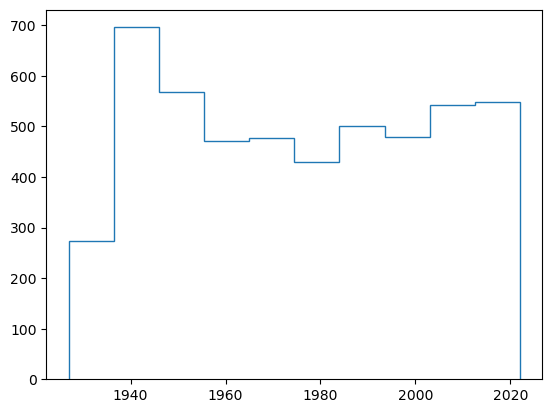

In [ ]:
plt.hist(awards_condensed.year, histtype='step') 

## IMDB ZONE

In [ ]:
IMDB_PATH = 'imdb_ratings_all_time/movies_imdb.csv'

In [ ]:
imdb_vanilla = pd.read_csv(DATA_PATH+IMDB_PATH, usecols=['id', 'name', 'year', 'rating', 'duration', 'votes', 'gross_income'], low_memory=False)

display(imdb_vanilla.sample(5))
display(imdb_vanilla.shape)
display(imdb_vanilla.info())
imdb_vanilla.isnull().sum()

,id,name,year,rating,duration,votes,gross_income
393062,tt7217486,Invisible Nights,(2016),11.0,48 min,0,0
975437,tt8219446,"Whitesnake: Fool for Your Loving, Version 1",(1980 Music Video),6.0,4 min,13,0
1682195,tt1454449,Best of UFC Fight Night,(2008 Video),7.4,110 min,15,0
2147077,tt0056323,Murder Can Be Deadly,(1962),6.4,60 min,107,0
2341562,tt11005270,Lingo,(1989–2014),11.0,0 min,0,0


(2590932, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590932 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 138.4+ MB


None

id              0
name            4
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

In [ ]:
imdb = imdb_vanilla.copy(deep=True)
imdb = imdb_vanilla.loc[~imdb_vanilla.name.isnull()]


display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())
imdb.isnull().sum()

,id,name,year,rating,duration,votes,gross_income
453255,tt14236588,Streamed Shakespeare,(2020– ),11.0,0 min,0,0
2305,tt5332206,Signal,(2016),8.5,80 min,"6,735","39,673,161"
291347,tt0501210,13 Demon Street,(1959–1960),6.6,0 min,16,0
838000,tt13163718,Will you Mr Sax,(2020 Video),11.0,6 min,0,0
1578216,tt20778318,Amar en tiempos revueltos,(2005– ),11.0,0 min,0,0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

id              0
name            0
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

In [ ]:
imdb[imdb['gross_income']!='0'].sample(5)

,id,name,year,rating,duration,votes,gross_income
2251369,tt0464165,The Queen's Sister,(2005 TV Movie),6.2,96 min,285,"300,000"
11834,tt0347573,Most Wanted,(2000),7.7,102 min,8,"6,758,000"
1995251,tt0102395,Mannequin: On the Move,(1991),4.3,95 min,6322,"3,752,426"
720248,tt0068662,The Great Waltz,(1972),5.0,135 min,249,"890,450"
1285727,tt0324618,La yegua colorada,(1973),7.0,88 min,19,"3,603,615"


In [ ]:
def clean_gross_income(value):
    if isinstance(value, str):
        value = value.replace(',', '').replace('$', '')
        if 'M' in value:
            value = float(value.replace('M', '')) * (10**6)
    return float(value)


In [ ]:
imdb.loc[:, 'gross_income'] = imdb['gross_income'].apply(lambda x: clean_gross_income(x))
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())
imdb[imdb['gross_income']!=0].sample(5)

,id,name,year,rating,duration,votes,gross_income
209490,tt2035949,Garo: Makaisenki,(2011– ),8.7,0 min,63,0.0
2546484,tt6041900,Extra! Extra!,(2006–2012),11.0,0 min,0,0.0
1392654,tt1844305,Femme Fatales,(2011–2012),7.4,30 min,92,0.0
1807146,tt1735650,Maestro,(1979–1989),11.0,0 min,0,0.0
1586659,tt2431734,Naruto: Shippûden,(2007–2017),6.3,23 min,237,0.0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

,id,name,year,rating,duration,votes,gross_income
833989,tt0086998,Breakin',(1984),5.8,87 min,6429,38682707.0
11208,tt0382621,Cronicas,(2004),6.8,108 min,3443,299261.0
381771,tt2400377,Kaksparsh,(2012),8.0,140 min,857,97711.0
195422,tt0058050,The Earth Dies Screaming,(1964),5.8,62 min,"1,875",742.0
721160,tt1247693,Sister Mary,(2011),3.1,100 min,114,3400000.0


In [ ]:
imdb.loc[:, 'votes'] = imdb['votes'].str.replace(',', '').astype(float)
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

,id,name,year,rating,duration,votes,gross_income
1175278,tt13313784,The New Adventures of Pinocchio,(1960– ),11.0,0 min,0.0,0.0
894254,tt14329964,Siti Nordiana: Angkara,(2020 Video),11.0,0 min,0.0,0.0
188745,tt1257099,Reilly: Ace of Spies,(1983),7.8,51 min,56.0,0.0
1388211,tt1699658,The Extraordinary,(1993–1996),11.0,0 min,0.0,0.0
730407,tt4531334,Le Rêve de Giuseppe,(2015),11.0,17 min,0.0,0.0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

In [ ]:
imdb.loc[:, 'year'] = imdb['year'].str.extract(r'(\d+)', expand=False)
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

,id,name,year,rating,duration,votes,gross_income
1723954,tt11087744,Tamanna,2016,11.0,0 min,0.0,0.0
1616812,tt5531244,Intrepid Journeys,2003,11.0,0 min,0.0,0.0
2125489,tt8145154,Dance Dance Dance,2018,11.0,9 min,0.0,0.0
1712744,tt0993041,Al rojo vivo con María Celeste,2002,11.0,0 min,0.0,0.0
2138593,tt14372686,Superior Soldiers,1993,11.0,0 min,0.0,0.0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

In [ ]:
# generate_missing_info(imdb)

imdb.loc[:, 'duration'] = imdb['duration'].str.extract(r'(\d+)', expand=False)
imdb.loc[:,'duration'] = imdb['duration'].astype(float)
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

,id,name,year,rating,duration,votes,gross_income
804922,tt3464630,Pancake Manor,2011,11.0,0.0,0.0,0.0
2419415,tt16000472,It's Okay to Laugh!,1982,11.0,0.0,0.0,0.0
247573,tt14131366,The Sigil,2020,11.0,12.0,0.0,0.0
1888108,tt7826588,The Rich Eisen Show,2014,11.0,0.0,0.0,0.0
2323755,tt0807391,Ca$h Cab,2005,11.0,0.0,0.0,0.0


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

In [ ]:
imdb.loc[:, 'duration'] = imdb['duration'].replace(0, np.nan)
imdb.loc[:, 'votes'] = imdb['votes'].replace(0, np.nan)
imdb.loc[:, 'gross_income'] = imdb['gross_income'].replace(0, np.nan)
imdb.loc[pd.isna(imdb['votes']), 'rating'] = np.nan
imdb

display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
2027660,tt0657159,Nanny and the Professor,1970,7.3,23.0,26.0,NaN
1897563,tt8884982,NFL Live,1991,NaN,NaN,NaN,NaN
651610,tt12321028,Judge Mills Lane,1998,NaN,NaN,NaN,NaN
1109346,tt10046190,Ballybraddan,2008,NaN,NaN,NaN,NaN
969296,tt19844698,Tanham Bezar,2014,NaN,NaN,NaN,NaN


(2590928, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 2590928 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 158.1+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.51
rating,75.66
duration,62.08
votes,75.66
gross_income,98.38


In [ ]:
imdb = imdb.dropna(subset=['year', 'duration']).reset_index(drop=True)
imdb = imdb.dropna(subset=['votes', 'gross_income'], how='all').reset_index(drop=True)

display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
11270,tt14668192,Elite Short Stories: Guzmán Caye Rebe,2021,7.4,36.0,2313.0,NaN
383557,tt4290974,Taking Earth,2017,2.6,100.0,1173.0,NaN
426611,tt0469722,All My Crazy Friends: The Movie,1998,8.5,39.0,16.0,NaN
220422,tt12072206,Thunderbolt Fantasy: Bewitching Melody of the ...,2019,7.8,90.0,43.0,NaN
248355,tt0927394,Ouran High School Host Club,2006,7.8,23.0,96.0,NaN


(470380, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470380 entries, 0 to 470379
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            470380 non-null  object 
 1   name          470380 non-null  object 
 2   year          470380 non-null  object 
 3   rating        470332 non-null  float64
 4   duration      470380 non-null  object 
 5   votes         470332 non-null  object 
 6   gross_income  39028 non-null   object 
dtypes: float64(1), object(6)
memory usage: 25.1+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.01
duration,0.00
votes,0.01
gross_income,91.70


In [ ]:
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb = imdb[imdb['year'] <= 2017].reset_index(drop=True)
display(imdb.sample(5))
display(imdb.shape)
display(imdb.info())

generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
136389,tt1400059,Billy the Exterminator,2009,9.2,22.0,6.0,NaN
260483,tt0274881,Het spook van Monniksveer,1989,4.7,64.0,9.0,NaN
213921,tt0807597,Fireball XL5,1962,7.9,26.0,13.0,NaN
22480,tt0257587,Ellos trajeron la violencia,1990,5.8,90.0,11.0,NaN
355953,tt1683412,Des Kaisers neue Kleider,2010,6.3,58.0,165.0,NaN


(413721, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413721 entries, 0 to 413720
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            413721 non-null  object 
 1   name          413721 non-null  object 
 2   year          413721 non-null  int64  
 3   rating        413691 non-null  float64
 4   duration      413721 non-null  object 
 5   votes         413691 non-null  object 
 6   gross_income  31330 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 22.1+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.01
duration,0.00
votes,0.01
gross_income,92.43


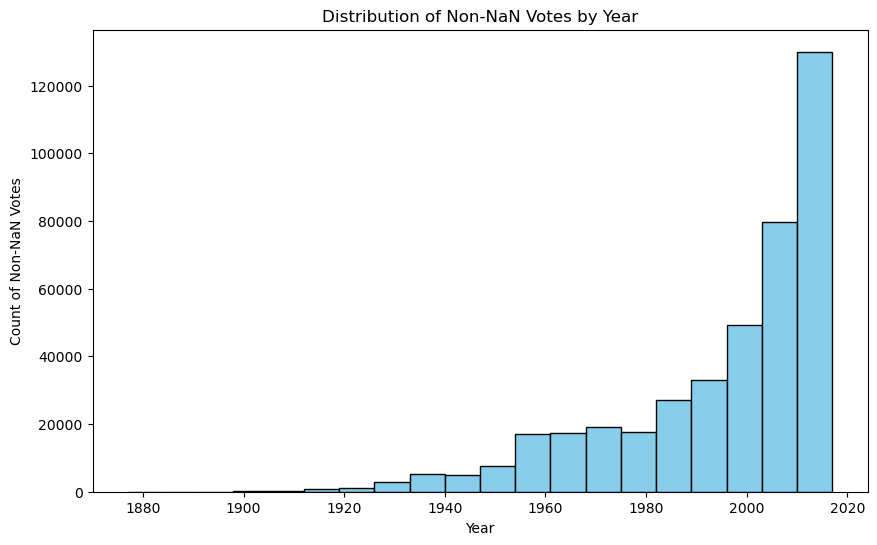

In [ ]:
non_nan_votes = imdb.dropna(subset=['votes'])

plt.figure(figsize=(10, 6))
plt.hist(non_nan_votes['year'].astype(int), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Count of Non-NaN Votes')
plt.title('Distribution of Non-NaN Votes by Year')
plt.show()

In [ ]:
imdb = imdb[imdb['rating'] <= 10]
max_rating = imdb['rating'].max()
min_rating = imdb['rating'].min()

print(f'Highest Rating: {max_rating}')
print(f'Lowest Rating: {min_rating}')
display(imdb[imdb['rating'] == max_rating])

Highest Rating: 10.0
Lowest Rating: 1.0


,id,name,year,rating,duration,votes,gross_income
21528,tt3843938,Control Policial,2014,10.0,11.0,6.0,NaN
22589,tt4188692,"One Night, in an Alley",2014,10.0,13.0,5.0,NaN
24961,tt0393944,"Das Vergnügen, anständig zu sein",1962,10.0,55.0,10.0,NaN
26083,tt2078578,Crybabies,2011,10.0,13.0,7.0,NaN
29291,tt1513828,Monkeywrench,2010,10.0,10.0,5.0,NaN
...,...,...,...,...,...,...,...
403020,tt0479077,Intimate Portrait,1990,10.0,60.0,188.0,NaN
403090,tt1007848,A Taste of My Life,2006,10.0,30.0,97.0,NaN
405845,tt0643318,The Match Game,1962,10.0,25.0,25.0,NaN
406354,tt1007457,The Match Game,1962,10.0,25.0,23.0,NaN


In [ ]:
display(imdb[imdb['name']=='Star Wars'])

,id,name,year,rating,duration,votes,gross_income
282048,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


In [ ]:
display(check_doublons(imdb, col_check=['name'], year='year', runtime='duration'))
display(imdb[imdb['name'].str.contains('Chopped')])
display(imdb[imdb['name']=='Wanted'])

Rows with real duplicates: 
                          name  year duration
752                     Wanted  2016     60.0
1170                   Maigret  2016     88.0
3900             Unconditional  2012     92.0
5096     Fixer Upper Mysteries  2017     90.0
5124               Blood Money  2012    109.0
...                        ...   ...      ...
413716               Jeopardy!  1984     30.0
413717              Shark Tank  2009     43.0
413718               Jeopardy!  1984     30.0
413719                 Chopped  2007     42.0
413720                 Chopped  2007     42.0

[182366 rows x 3 columns]
--------------------------------------------------------------------------------


None

,id,name,year,rating,duration,votes,gross_income
124945,tt1353281,Chopped,2007,7.4,60.0,3925.0,NaN
126011,tt3470148,Chopped Canada,2014,5.7,60.0,175.0,NaN
131091,tt10040750,Chopped,2007,8.6,42.0,11.0,NaN
131092,tt10040760,Chopped,2007,8.6,42.0,9.0,NaN
131193,tt10122940,Chopped,2007,8.9,42.0,9.0,NaN
...,...,...,...,...,...,...,...
413683,tt9732040,Chopped,2007,8.9,42.0,8.0,NaN
413691,tt9788470,Chopped,2007,8.4,42.0,8.0,NaN
413692,tt9788480,Chopped,2007,8.7,42.0,7.0,NaN
413719,tt9893108,Chopped,2007,9.0,42.0,7.0,NaN


,id,name,year,rating,duration,votes,gross_income
332,tt0493464,Wanted,2008,6.7,110.0,384407.0,134508551.0
752,tt5193358,Wanted,2016,7.6,60.0,5894.0,35000000.0
4262,tt1084972,Wanted,2009,6.6,147.0,24136.0,NaN
29535,tt1595489,Wanted,2009,4.8,5.0,6.0,NaN
127901,tt0808117,Wanted,1996,7.5,60.0,19.0,NaN
205519,tt0220845,Wanted,1999,3.7,12.0,12.0,NaN
240413,tt0062047,Wanted,1967,6.0,107.0,398.0,NaN
244002,tt7256136,Wanted,2017,6.3,8.0,29.0,NaN
244637,tt4559204,Wanted,2015,7.0,10.0,5.0,NaN
355845,tt0214292,Wanted,1999,6.7,90.0,431.0,NaN


In [ ]:
imdb_clean = imdb.copy(deep=True)
imdb_clean = fuse_duplicates(imdb, col_check=['name'], year='year', runtime='duration', col_len=[], col_null=['rating', 'votes', 'gross_income'])

display(imdb_clean.sample(5))
display(imdb_clean.shape)
display(imdb_clean.info())

Fusing duplicates: 


KeyboardInterrupt: 

## MOVIE STATS ZONE

In [ ]:
display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())
display(generate_missing_info(movies_stats))
display(check_doublons(movies_stats, ['name'], 'year', 'runtime'))

,name,year,review,nbr_review,countries,revenue,runtime
5326,Milk,2008,7.5,167000.0,United States,54589558.0,128.0
4542,Taxi,2004,4.5,41000.0,United States,71255003.0,97.0
196,Paternity,1981,4.9,920.0,United States,18838812.0,94.0
4187,Dahmer,2002,5.6,9700.0,United States,144008.0,101.0
2841,The Walking Dead,1995,4.9,759.0,United States,6014341.0,88.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        5377 non-null   object 
 1   year        5377 non-null   int64  
 2   review      5377 non-null   float64
 3   nbr_review  5377 non-null   float64
 4   countries   5377 non-null   object 
 5   revenue     5377 non-null   float64
 6   runtime     5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
review,0.00
nbr_review,0.00
countries,0.00
revenue,0.00
runtime,0.02


No duplicates
--------------------------------------------------------------------------------


None

In [ ]:
display(movies_stats[movies_stats['name'].str.contains('Star Wars')])

,name,year,review,nbr_review,countries,revenue,runtime
2,Star Wars: Episode V - The Empire Strikes Back,1980,8.7,1200000.0,United States,5.383751e+08,124.0
333,Star Wars: Episode VI - Return of the Jedi,1983,8.3,973000.0,United States,4.751062e+08,131.0
3451,Star Wars: Episode I - The Phantom Menace,1999,6.5,748000.0,United States,1.027083e+09,136.0
4058,Star Wars: Episode II - Attack of the Clones,2002,6.5,658000.0,United States,6.537800e+08,142.0
4658,Star Wars: Episode III - Revenge of the Sith,2005,7.5,729000.0,United States,8.683906e+08,140.0
5366,Star Wars: The Clone Wars,2008,5.9,61000.0,United States,6.828284e+07,98.0
6663,Star Wars: Episode VII - The Force Awakens,2015,7.8,876000.0,United States,2.069522e+09,138.0
6869,Rogue One: A Star Wars Story,2016,7.8,572000.0,United States,1.056058e+09,133.0
7075,Star Wars: Episode VIII - The Last Jedi,2017,7.0,581000.0,United States,1.332699e+09,152.0
7261,Solo: A Star Wars Story,2018,6.9,306000.0,United States,3.929248e+08,135.0


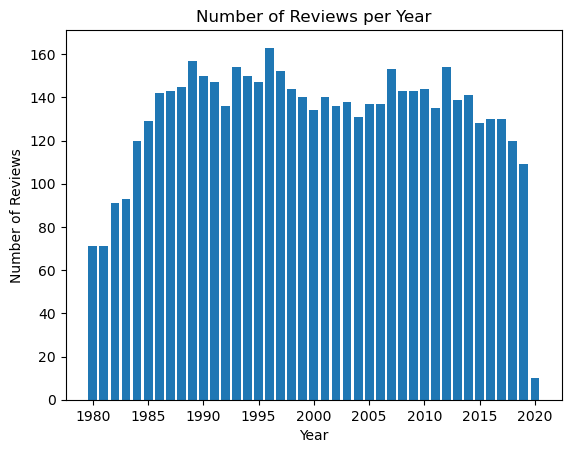

In [ ]:
reviews_count_per_year_stats = movies_stats.groupby('year')['review'].count().reset_index()

plt.bar(reviews_count_per_year_stats['year'], reviews_count_per_year_stats['review'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.show()

## MOVIELENS ZONE

In [ ]:
display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())

,revenue,runtime,name,review,nbr_review,year
2545,4409328.0,91.0,Run,5.5,13.0,1991
1100,1012189.0,72.0,Dracula,7.2,254.0,1931
2208,68349884.0,91.0,Ghost Ship,5.3,540.0,2002
4299,19504039.0,107.0,Margin Call,6.7,531.0,2011
2796,30039392.0,99.0,Shaun of the Dead,7.5,2479.0,2004


(5619, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   revenue     5619 non-null   float64
 1   runtime     5619 non-null   float64
 2   name        5619 non-null   object 
 3   review      5619 non-null   float64
 4   nbr_review  5619 non-null   float64
 5   year        5619 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 241.6+ KB


None

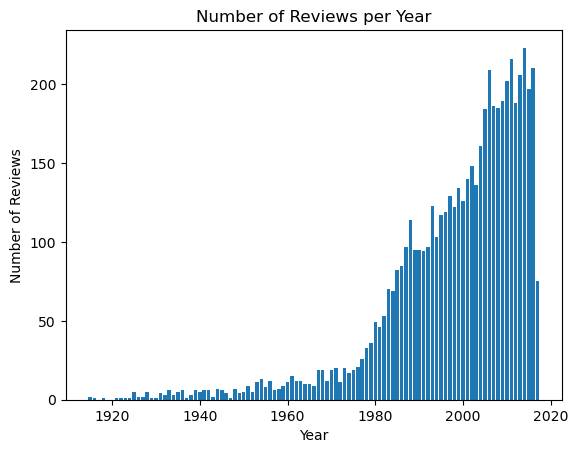

In [ ]:
reviews_count_per_year_lens = movies_lens.groupby('year')['review'].count().reset_index()

plt.bar(reviews_count_per_year_lens['year'], reviews_count_per_year_lens['review'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.show()

## MOVIELENS ZONE (REV & RATINGS) OLD AND TRASH

### Ratings

In [ ]:
BIG_RATINGS_PATH = '/ml-latest/ratings.csv'

In [ ]:
spark = SparkSession.builder.appName("Ratings").getOrCreate()
big_ratings = spark.read.csv(DATA_PATH+BIG_RATINGS_PATH, header=True, inferSchema=True)
big_ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|    260|   4.5|1225735204|
|     1|    356|   5.0|1225735119|
+------+-------+------+----------+
only showing top 5 rows



In [ ]:
big_ratings_clean = big_ratings.groupBy("movieId").agg(
    F.avg("rating").alias("average_rating"),
    F.count("rating").alias("nbr_ratings")
)

big_ratings_clean.show()

+-------+------------------+-----------+
|movieId|    average_rating|nbr_ratings|
+-------+------------------+-----------+
|   1959| 3.633800573431029|       6278|
|   1591|2.6484306887532694|       6882|
|   1580| 3.595333426758223|      49951|
|   1645|  3.56697669143084|      17633|
|  44022|3.2430483271375463|       6725|
|   3175| 3.602825957745718|      18507|
|  32460|4.0208131655372705|       1033|
| 280218|3.4652701212789414|        907|
|    148|               2.9|        380|
|    471| 3.651588858375834|      12745|
|   8638| 4.005075757575757|       6600|
|  96488| 3.993886230728336|       1881|
|    496|3.3140877598152425|        433|
|   1088| 3.274450709702508|      15429|
|   2366|3.4753840782122905|       8592|
|   3918| 3.014236902050114|       1756|
|   1342|  3.02922642329422|       4602|
|  54190| 3.552968186290587|       3049|
|   7833| 3.819178082191781|        365|
|  31983|           3.53125|         48|
+-------+------------------+-----------+
only showing top

In [ ]:
num_rows = big_ratings_clean.count()
num_columns = len(big_ratings_clean.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 83239
Number of columns: 3


In [ ]:
big_ratings_pd = big_ratings_clean.toPandas().rename(columns={'movieId': 'id'})
spark.stop()
display(big_ratings_pd.sample(5))
display(big_ratings_pd.shape)
display(big_ratings_pd.info())

,id,average_rating,nbr_ratings
38628,160838,3.000000,3
21226,272447,2.750000,2
25550,228665,0.500000,1
2040,73511,2.723214,168
19491,159221,3.500000,8


(83239, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83239 entries, 0 to 83238
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              83239 non-null  int32  
 1   average_rating  83239 non-null  float64
 2   nbr_ratings     83239 non-null  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 1.6 MB


None

In [ ]:
display(big_ratings_pd.nbr_ratings.sort_values(ascending=False))
display(big_ratings_pd.average_rating.sort_values(ascending=False))

31405    122296
47237    113581
1123     108756
28098    107056
1616     101802
          ...  
13287         1
13288         1
13290         1
13292         1
83238         1
Name: nbr_ratings, Length: 83239, dtype: int64

35220    5.0
10911    5.0
13181    5.0
5227     5.0
2604     5.0
        ... 
82168    0.5
38833    0.5
82166    0.5
23567    0.5
13703    0.5
Name: average_rating, Length: 83239, dtype: float64

In [ ]:
RATING_PATH = 'movie_lens/ratings.csv'

In [ ]:
ratings_vanilla = pd.read_csv(DATA_PATH+RATING_PATH).drop(columns=['timestamp']).rename(columns={'movieId': 'id'})
display(ratings_vanilla.sample(5))
display(ratings_vanilla.shape)
display(ratings_vanilla.info())

,userId,id,rating
1835345,19028,4980.0,3.5
1365507,14046,4710.0,5.0
830309,8534,2124.0,4.0
2149097,22297,527.0,2.5
3914052,40680,2683.0,4.0


(7074477, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7074477 entries, 0 to 7074476
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   userId  int64  
 1   id      float64
 2   rating  float64
dtypes: float64(2), int64(1)
memory usage: 161.9 MB


None

In [ ]:
ratings = ratings_vanilla.copy(deep=True)
ratings = ratings.groupby('id').agg(average_rating=('rating', 'mean'),nbr_ratings=('rating', 'count')).reset_index()

display(ratings.sample(5))
display(ratings.shape)
display(ratings.info())

,id,average_rating,nbr_ratings
20013,102062.0,3.266667,15
24711,125269.0,4.500000,1
20167,102760.0,3.500000,6
13699,69444.0,2.250000,6
11566,51207.0,2.571429,7


(36379, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36379 entries, 0 to 36378
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              36379 non-null  float64
 1   average_rating  36379 non-null  float64
 2   nbr_ratings     36379 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 852.8 KB


None

### Revenue

In [ ]:
# Load MovieLens DF, need to modify it compared to M2 !

movies_lens_vanilla = pd.read_csv(MOVIE_LENS, usecols=['id', 'title', 'release_date', 'production_countries', 'revenue', 'runtime'])
movies_lens_vanilla = movies_lens_vanilla.rename(columns={'production_countries': 'countries',                                                     
                                                         'title': 'name'})
display(movies_lens_vanilla.sample(5))
display(movies_lens_vanilla.shape)
display(movies_lens_vanilla.info())

,id,countries,release_date,revenue,runtime,name
27812,43754,"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-02-14,0.0,92.0,The Killing Jar
37637,41988,"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-07-27,0.0,12.0,DC Showcase: Jonah Hex
43089,52280,"[{'iso_3166_1': 'US', 'name': 'United States o...",1933-03-03,0.0,21.0,The Fatal Glass of Beer
35824,303665,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2014-10-23,0.0,92.0,Journey to Le Mans
19939,97598,"[{'iso_3166_1': 'US', 'name': 'United States o...",1941-12-18,0.0,88.0,Kathleen


(45466, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            45466 non-null  object 
 1   countries     45463 non-null  object 
 2   release_date  45379 non-null  object 
 3   revenue       45460 non-null  float64
 4   runtime       45203 non-null  float64
 5   name          45460 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


None

In [ ]:
# WASH MACHINE

movies_lens = movies_lens_vanilla.copy(deep=True)
zero_data = movies_lens[(movies_lens.revenue <= 0)|(movies_lens.revenue.isna()|movies_lens.release_date.isna())]
movies_lens.drop(zero_data.index,inplace=True)
movies_lens.reset_index(drop=True, inplace=True)

movies_lens.loc[:, 'year'] = movies_lens['release_date'].str.split('-', expand=True)[0]
movies_lens.loc[:, 'year'] = movies_lens['year'].astype(int)
movies_lens = movies_lens.drop(columns='release_date')


movies_lens.loc[movies_lens['runtime'] < 0, 'runtime'] = 0
movies_lens['runtime'] = movies_lens['runtime'].replace(0, pd.NA)

movies_lens['year'] = movies_lens['year'].astype(int)
movies_lens['runtime'] = pd.to_numeric(movies_lens['runtime'], errors='coerce')

# Handling format
movies_lens['countries'] = movies_lens['countries'].apply(lambda x: [country['name'] for country in ast.literal_eval(x)] if pd.notna(x) else [])

# Handle multi-countries movies to keep only one country per movie (prioritize USA above others)
movies_lens = separate_values_biased(movies_lens, 'countries', 'United States of America')
movies_lens = movies_lens[movies_lens['countries']=='United States of America'].drop(columns='countries')

display(check_doublons(movies_lens, ['name'], 'year', 'runtime'))

movies_lens = fuse_duplicates(movies_lens, col_check=['name'], year='year', runtime='runtime',
                         col_len=[], col_null=['revenue'])

check_doublons(movies_lens, ['name'], 'year', 'runtime')

movies_lens['id'] = movies_lens['id'].astype(int)

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())


Rows with real duplicates: 
                                             name  year  runtime
415                            A Farewell to Arms  1932     89.0
2301                                Clockstoppers  2002     94.0
2444  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
2548              Confessions of a Dangerous Mind  2002    113.0
4721                           A Farewell to Arms  1932     89.0
6692                                Clockstoppers  2002     94.0
6695              Confessions of a Dangerous Mind  2002    113.0
7381  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


,id,revenue,runtime,name,year
1274,36094,5820015.0,104.0,Stanley & Iris,1990
3740,13825,558000.0,99.0,The Lazarus Project,2008
3809,18162,68688831.0,102.0,Land of the Lost,2009
1936,9778,77516304.0,90.0,Serendipity,2001
5472,14631,2025032.0,100.0,The Work and the Glory II: American Zion,2005


(5619, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       5619 non-null   int32  
 1   revenue  5619 non-null   float64
 2   runtime  5619 non-null   float64
 3   name     5619 non-null   object 
 4   year     5619 non-null   int32  
dtypes: float64(2), int32(2), object(1)
memory usage: 175.7+ KB


None

In [ ]:
display(movies[movies['name'].str.contains('Star Wars', case=False, na=False)])
display(movies_lens[movies_lens['name'].str.contains('Star Wars', case=False, na=False)])

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
4355,15726696,/m/0cpllql,Star Wars: The Clone Wars,2008,6.828284e+07,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute..."
5454,50957,/m/0dfw0,Star Wars Episode II: Attack of the Clones,2002,6.493983e+08,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
8240,1861566,/m/061wqh,Saving Star Wars,2004,NaN,117.0,[English Language],[USA],"[Indie, Comedy]"
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
28976,3336298,/m/096gqt,The Making of Star Wars,1977,NaN,50.0,[English Language],[USA],[Documentary]
45820,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
51167,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
51391,185264,/m/0199wf,The Star Wars Holiday Special,1978,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
57081,55447,/m/0fdv3,Star Wars Episode III: Revenge of the Sith,2005,8.487548e+08,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
62252,1823554,/m/05zsyv,Star Wars: Revelations,2005,NaN,47.0,[English Language],[USA],"[Fan film, Indie]"


,id,revenue,runtime,name,year
120,11,7.753980e+08,121.0,Star Wars,1977
1095,1893,9.243176e+08,136.0,Star Wars: Episode I - The Phantom Menace,1999
2094,1894,6.493983e+08,142.0,Star Wars: Episode II - Attack of the Clones,2002
3014,1895,8.500000e+08,140.0,Star Wars: Episode III - Revenge of the Sith,2005
3656,12180,6.828284e+07,98.0,Star Wars: The Clone Wars,2008
5037,140607,2.068224e+09,136.0,Star Wars: The Force Awakens,2015
5509,330459,1.056057e+09,133.0,Rogue One: A Star Wars Story,2016


### MOVIE LENS MERGE

In [ ]:
movies_lens_tot = pd.merge(big_ratings_pd, movies_lens, on='id', how='right')

display(movies_lens_tot.sample(5))
display(movies_lens_tot.shape)
display(movies_lens_tot.info())

,id,average_rating,nbr_ratings,revenue,runtime,name,year
2983,23916,NaN,NaN,7185518.0,107.0,Paradise Alley,1978
5097,201085,NaN,NaN,74679822.0,119.0,Crimson Peak,2015
114,47867,NaN,NaN,3992809.0,90.0,Gordy,1995
5448,278924,NaN,NaN,125729635.0,99.0,Mechanic: Resurrection,2016
975,12118,NaN,NaN,43579163.0,83.0,Police Academy 3: Back in Training,1986


(5619, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5619 non-null   int32  
 1   average_rating  1657 non-null   float64
 2   nbr_ratings     1657 non-null   float64
 3   revenue         5619 non-null   float64
 4   runtime         5619 non-null   float64
 5   name            5619 non-null   object 
 6   year            5619 non-null   int32  
dtypes: float64(4), int32(2), object(1)
memory usage: 263.5+ KB


None

In [ ]:
# Check for missing values in big_ratings_pd
print(big_ratings_pd["id"].isnull().sum())

# Check for missing values in movies_lens
print(movies_lens["id"].isnull().sum())

# Check unique values in big_ratings_pd
print(big_ratings_pd["id"].unique())

# Check unique values in movies_lens
print(movies_lens["id"].unique())

mismatched_entries = pd.merge(big_ratings_pd, movies_lens, on="id", how="outer", indicator=True).query('_merge != "both"')
print(mismatched_entries.head())

0
0
[  1959   1591   1580 ... 264496 215885 189287]
[   862   8844  31357 ... 353491 378236 395834]
       id  average_rating  nbr_ratings  revenue  runtime name  year     _merge
0    1959        3.633801       6278.0      NaN      NaN  NaN   NaN  left_only
1    1591        2.648431       6882.0      NaN      NaN  NaN   NaN  left_only
4   44022        3.243048       6725.0      NaN      NaN  NaN   NaN  left_only
6   32460        4.020813       1033.0      NaN      NaN  NaN   NaN  left_only
7  280218        3.465270        907.0      NaN      NaN  NaN   NaN  left_only


In [ ]:
movie_lens_tot2 = pd.merge(ratings, movies_lens, on='id', how='right')

display(movie_lens_tot2.sample(5))
display(movie_lens_tot2.shape)
display(movie_lens_tot2.info())

,id,average_rating,nbr_ratings,revenue,runtime,name,year
4525,58547.0,NaN,NaN,201146.0,100.0,10 Years,2011
1862,9972.0,NaN,NaN,22099847.0,115.0,Lock Up,1989
1031,18588.0,NaN,NaN,5186646.0,110.0,52 Pick-Up,1986
4268,72711.0,NaN,NaN,282448.0,125.0,The Interrupters,2011
2492,10147.0,NaN,NaN,76488889.0,91.0,Bad Santa,2003


(5619, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5619 non-null   float64
 1   average_rating  1536 non-null   float64
 2   nbr_ratings     1536 non-null   float64
 3   revenue         5619 non-null   float64
 4   runtime         5619 non-null   float64
 5   name            5619 non-null   object 
 6   year            5619 non-null   int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 285.5+ KB


None

## TRASH CAN UNDERNEATH

In [ ]:
movies3 = movies2_clean.copy()
movies3 = pd.merge(movies2_clean, awards_condensed, on=['name', 'year'], how='left')

display(movies3.sample(5))
display(movies3.shape)
display(movies3.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,year_ceremony,ceremony,cat_nominated,name_nominated,winner
1515,6469252,/m/0g6j0h,Shooter,2007,126.0,[English Language],[USA],"[Thriller, Film adaptation, Action/Adventure, ...",NaN,NaN,95696996.0,0.004946,NaN,NaN,NaN,NaN,NaN
5349,23270459,/m/0661ql3,Inception,2010,148.0,"[French Language, Japanese Language, English L...","[USA, United Kingdom]","[Thriller, Science Fiction, Adventure, Psychol...",8.795340,2114075.0,828358814.75,0.03707,2011.0,83.0,"[ART DIRECTION, CINEMATOGRAPHY, MUSIC (Origina...",[Production Design: Guy Hendrix Dyas; Set Deco...,"[False, True, False, False, True, True, True, ..."
1191,7271954,/m/0kv2w7,Blood and Chocolate,2007,98.0,"[Romanian Language, English Language]","[USA, Romania, United Kingdom, Germany]","[Crime Fiction, Horror, Creature Film, Drama, ...",NaN,NaN,6311117.0,0.000326,NaN,NaN,NaN,NaN,NaN
5709,770156,/m/03b1n2,But I'm a Cheerleader,1999,85.0,[English Language],[USA],"[Romantic comedy, Gay Interest, Comedy-drama, ...",6.699306,29101.0,2596412.0,0.0002,NaN,NaN,NaN,NaN,NaN
3264,18996,/m/04ssf,Mean Streets,1973,112.0,"[Italian Language, English Language]",[USA],"[Crime Fiction, Drama, Coming of age, Gangster...",NaN,NaN,3000000.0,0.002468,NaN,NaN,NaN,NaN,NaN


(7285, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_wiki         7285 non-null   int64  
 1   id_freebase     7285 non-null   object 
 2   name            7285 non-null   object 
 3   year            7285 non-null   int32  
 4   runtime         7260 non-null   float64
 5   lang            7285 non-null   object 
 6   countries       7285 non-null   object 
 7   genres          7285 non-null   object 
 8   review          2898 non-null   float64
 9   nbr_review      2898 non-null   float64
 10  revenue         7285 non-null   object 
 11  revenue_part    7285 non-null   object 
 12  year_ceremony   1277 non-null   float64
 13  ceremony        1277 non-null   float64
 14  cat_nominated   1277 non-null   object 
 15  name_nominated  1277 non-null   object 
 16  winner          1277 non-null   object 
dtypes: float64(5), int32(1), int64(1)

None

In [ ]:
movies3['oscar_nomination'] = pd.notna(movies3['ceremony'])

In [ ]:
movies3.insert(movies3.columns.get_loc('revenue_part') + 1, 'oscar_nomination', movies3.pop('oscar_nomination'))
movies3 = movies3.drop(columns=['year_ceremony', 'ceremony'])

display(movies3.sample(5))
display(movies3.shape) 
display(movies3.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,oscar_nomination,cat_nominated,name_nominated,winner
5439,30296552,/m/0g5r4sy,Another Earth,2011,90.0,[English Language],[USA],"[Science Fiction, Mystery, Fantasy, Drama, Rom...",NaN,NaN,1776935.0,0.000077,False,NaN,NaN,NaN
651,779536,/m/03bq6g,Fat Man and Little Boy,1989,126.0,[English Language],[USA],"[Period piece, Drama, War film]",NaN,NaN,3563162.0,0.000595,False,NaN,NaN,NaN
1565,4845206,/m/0cqnq8,Sodom and Gomorrah,1962,120.0,[English Language],"[USA, France, Italy]","[History, Drama, Adventure, Historical drama]",NaN,NaN,2300000.0,0.008804,False,NaN,NaN,NaN
2013,430975,/m/027p7w,Harvard Man,2002,99.0,[English Language],"[USA, Canada]","[Crime Fiction, Thriller, Gangster Film, Indie...",NaN,NaN,56653.0,0.000003,False,NaN,NaN,NaN
3056,386476,/m/0227ry,The Frisco Kid,1979,114.0,[English Language],[USA],"[Action/Adventure, Western, Buddy film, Comedy...",6.0,38.0,9346177.0,0.004882,False,NaN,NaN,NaN


(7285, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_wiki           7285 non-null   int64  
 1   id_freebase       7285 non-null   object 
 2   name              7285 non-null   object 
 3   year              7285 non-null   int32  
 4   runtime           7260 non-null   float64
 5   lang              7285 non-null   object 
 6   countries         7285 non-null   object 
 7   genres            7285 non-null   object 
 8   review            2898 non-null   float64
 9   nbr_review        2898 non-null   float64
 10  revenue           7285 non-null   object 
 11  revenue_part      7285 non-null   object 
 12  oscar_nomination  7285 non-null   bool   
 13  cat_nominated     1277 non-null   object 
 14  name_nominated    1277 non-null   object 
 15  winner            1277 non-null   object 
dtypes: bool(1), float64(3), int32(1), int64(1)

None